In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import top_k_accuracy_score
from LANCZOS import LANCZOS
import copy 
import json
with open('dataset.json', 'r') as json_file:
    DataSet = json.load(json_file)
    
#os.environ["CUDA_VISIBLE_DEVICES"]="6, 7"

In [2]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from scipy.linalg import orth
import math

class myPCA():
    def __init__(self, n_components=-1):
        self.n_components = n_components
        self.PCA          = None

    def PCA_sklearn(self, X):
        self.PCA          = PCA(  n_components=self.n_components  )
        self.PCA.fit(X)
   
    def fit(self, X):
        if self.n_components < 0:
            self.n_components = X.shape[-1]
        X = X.reshape(  -1, X.shape[-1]  )
        self.PCA_sklearn(  X  )
        return self
            
    def transform(self, X):
        S = (list)(X.shape)
        S[-1] = -1
        X = X.reshape(  -1, X.shape[-1]  )
        tX = self.PCA.transform(X)
        return tX.reshape(S)
       
    def inverse_transform(self, X):
        S = (list)(X.shape)
        S[-1] = -1
        X = X.reshape(  -1, X.shape[-1]  )
        tX = self.PCA.inverse_transform(X)
        tX = tX.reshape(S)
        return tX
    
class LANCZOS:
    @staticmethod
    def split(X, ratio=2):
        DC_L = LANCZOS.resample(X, ratio)
        X_inv_L = LANCZOS.resample(DC_L, 1/ratio)
        X_inv_L = np.round(X_inv_L)
        AC = X - X_inv_L
        return DC_L, AC
    @staticmethod
    def inv_split(DC, AC, ratio=2):
        DC = LANCZOS.resample(DC, 1/ratio)
        return DC+AC
    def inv_split_moreRef(DC, AC, k, i, j, win, ratio=2):
        DC = LANCZOS.resample(DC, 1/ratio)
        DC = Shrink(DC, win=win)
        return DC[k, i, j].reshape(-1)+AC.reshape(-1)
    @staticmethod
    def resample(X, ratio=2):
        image_list = []
        for i in range(X.shape[0]):
            size1 = int(X.shape[1]/ratio)
            size2 = int(X.shape[2]/ratio)
            image_tmp = Image.fromarray(X[i,:,:,0]).resize(size=(size1, size2), resample=Image.LANCZOS)
            image_list.append(np.array(image_tmp).reshape(1, size1, size2, 1))
        output = np.concatenate(image_list, axis=0)
        return output

In [3]:
def slice_pca_VQ(X, win, n_channels, n_clusters, bit_map):
    print("--------one band start--------")
    X_tmp = Shrink(copy.deepcopy(X), win)
    S = X_tmp.shape
    X_tmp = X_tmp.reshape(-1, win*win)
#     choose the block that need to do VQ
    map_tmp = bit_map.reshape(X_tmp.shape[0])
    X_tt = X_tmp[map_tmp == 1]
    print("Window size: ", win)
#     pca
    pca_tmp = PCA(n_components=n_channels)
    X_pca = pca_tmp.fit_transform(X_tt)
    print("Pick the first ", n_channels, " channels, Energy ratio is: ", np.sum(pca_tmp.explained_variance_ratio_))
#     vq + inverse vq
    km_tmp = myKMeans(n_clusters=n_clusters, fast=True, gpu=False, n_threads=16, sort=False, saveObj=True).fit(X_pca)
    label_tmp = km_tmp.predict(X_pca)
    X_dVQ = km_tmp.inverse_predict(label_tmp)
    print("Codebook size: ", n_clusters)
#     inverse pca
    X_tt_inv = pca_tmp.inverse_transform(X_dVQ)
    X_pca_inv = np.zeros(X_tmp.shape)
    X_pca_inv[map_tmp == 1] = X_tt_inv
    X_inv = invShrink(X_pca_inv.reshape(S), win)
#     analyse result
    residual = X - X_inv
    mse = MSE(X, X_inv)
    print("MSE: ", mse)
    bits = X_tt.shape[0]*math.log(n_clusters,2)
    print("Bits: ", bits)
    print("--------one band stop---------")
#     return residual, pca_tmp, km_tmp, label_tmp
    return X_inv, residual, bits, mse
#     return X_inv, residual, bits, mse, pca_tmp, km_tmp, label_tmp


def check_block(X, win, mse_th, std_th):
    X_tmp = Shrink(copy.deepcopy(X), win)
    S = X_tmp.shape
    print(S)
#     S[-1] = 1
    X_tmp = X_tmp.reshape(-1, win*win)
#     X_ori_tmp = (Shrink(copy.deepcopy(X_ori), win)).reshape(-1, win*win)
    bit_map_tmp = np.ones((X_tmp.shape[0], 1), dtype=np.int32)
    count = 0
    for i in range(X_tmp.shape[0]):
        if np.mean(X_tmp[i]*X_tmp[i])<=mse_th:
            if np.std(X_tmp[i])<=std_th:
                bit_map_tmp[i] = 0
                count += 1
    print("flat area rate: ", count/X_tmp.shape[0])
    return bit_map_tmp.reshape((S[0], S[1], S[2], 1))

In [4]:
Y_list = Load_from_Folder(folder=DataSet['CLIC_train_1024x1024_more'], color='YUV', ct=-1)
Y_list = np.array(Y_list)

# Yt_list = Load_from_Folder(folder=DataSet['CLIC_test_1024x1024_more'], color='YUV', ct=-1)
# Yt_list = np.array(Yt_list)

DC_grid_10_Y_train, AC_grid_10_Y_train = LANCZOS.split(Y_list[:,:,:,0:1])
print(DC_grid_10_Y_train.shape, AC_grid_10_Y_train.shape)

DC_grid_9_Y_train, AC_grid_9_Y_train = LANCZOS.split(DC_grid_10_Y_train)
print(DC_grid_9_Y_train.shape, AC_grid_9_Y_train.shape)

DC_grid_8_Y_train, AC_grid_8_Y_train = LANCZOS.split(DC_grid_9_Y_train)
print(DC_grid_8_Y_train.shape, AC_grid_8_Y_train.shape)

DC_grid_7_Y_train, AC_grid_7_Y_train = LANCZOS.split(DC_grid_8_Y_train)
print(DC_grid_7_Y_train.shape, AC_grid_7_Y_train.shape)

DC_grid_6_Y_train, AC_grid_6_Y_train = LANCZOS.split(DC_grid_7_Y_train)
print(DC_grid_6_Y_train.shape, AC_grid_6_Y_train.shape)

DC_grid_5_Y_train, AC_grid_5_Y_train = LANCZOS.split(DC_grid_6_Y_train)
print(DC_grid_5_Y_train.shape, AC_grid_5_Y_train.shape)

(1427, 512, 512, 1) (1427, 1024, 1024, 1)
(1427, 256, 256, 1) (1427, 512, 512, 1)
(1427, 128, 128, 1) (1427, 256, 256, 1)
(1427, 64, 64, 1) (1427, 128, 128, 1)
(1427, 32, 32, 1) (1427, 64, 64, 1)
(1427, 16, 16, 1) (1427, 32, 32, 1)


In [5]:
# grid-5 band-1 new
codebook_size_32 = [8, 16, 32]
bit_map_1 = np.ones((1427, 1, 1), dtype=np.int32)
for c32 in codebook_size_32:
    X_inv_s1, r_s1, bits_s1, mse_s1 = slice_pca_VQ(AC_grid_5_Y_train, 32, 40, c32, bit_map_1)  # band 1
    

# grid-5 band-2 new
codebook_size_16 = [8, 32, 128]
bit_map_2 = np.ones((1427, 2, 2), dtype=np.int32)
for c16 in codebook_size_16:
    X_inv_s2, r_s2, bits_s2, mse_s2 = slice_pca_VQ(r_s1, 16, 25, c16, bit_map_2)  # band 2
    
    
# grid-5 band-3 new
codebook_size_8 = [8, 32, 128, 512]
bit_map_3 = np.ones((1427, 4, 4), dtype=np.int32)
for c8 in codebook_size_8:
    X_inv_s3, r_s3, bits_s3, mse_s3 = slice_pca_VQ(r_s2, 8, 12, c8, bit_map_3)  # band 3
    
    
# grid-5 band-4 new
codebook_size_4 = [8, 32, 128, 512, 2048]
bit_map_4 = np.ones((1427, 8, 8), dtype=np.int32)
for c4 in codebook_size_4:
    X_inv_s4, r_s4, bits_s4, mse_s4 = slice_pca_VQ(r_s3, 4, 16, c4, bit_map_4)  # band 4

--------one band start--------
Window size:  32
Pick the first  40  channels, Energy ratio is:  0.29414588
Codebook size:  8
MSE:  208.41655100922713
Bits:  4281.0
--------one band stop---------
--------one band start--------
Window size:  32
Pick the first  40  channels, Energy ratio is:  0.29437396
Codebook size:  16
MSE:  204.23357759897314
Bits:  5708.0
--------one band stop---------
--------one band start--------
Window size:  32
Pick the first  40  channels, Energy ratio is:  0.29425833
Codebook size:  32
MSE:  199.48437712448353
Bits:  7135.0
--------one band stop---------
--------one band start--------
Window size:  16
Pick the first  25  channels, Energy ratio is:  0.36052318668717676
Codebook size:  8
MSE:  191.2776892049194
Bits:  17124.0
--------one band stop---------
--------one band start--------
Window size:  16
Pick the first  25  channels, Energy ratio is:  0.36001596600616964
Codebook size:  32
MSE:  181.67433222107783
Bits:  28540.0
--------one band stop---------
---

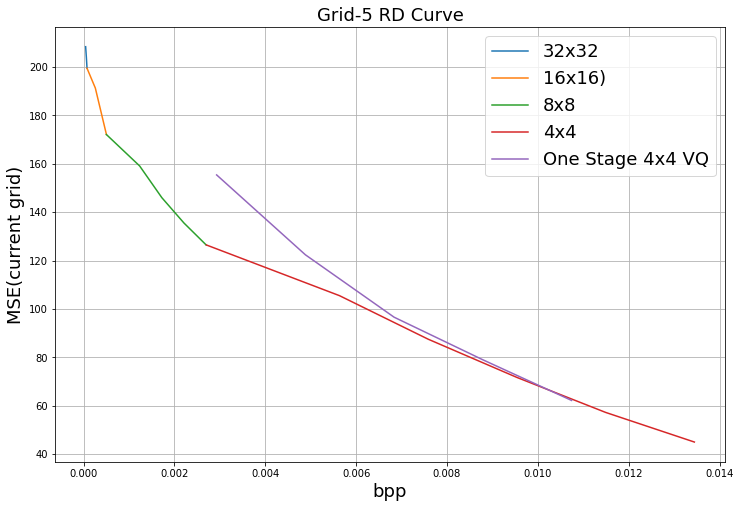

In [7]:
# oveerall RD

# 40 25 12

r1 = [4281/1427/1024/1024, 5708/1427/1024/1024, 7135/1427/1024/1024]
r1 = np.array(r1)*16
d1 = [208.4, 204.2, 199.48]

r2 = [0.00000476, 0.00000476+17124/1427/1024/1024, 0.00000476+28540/1427/1024/1024, 0.00000476+39956/1427/1024/1024]
r2 = np.array(r2)*16
d2 = [199.48, 191.3, 181.7, 172.1]

r3 = [0.0000314, 0.0000314+68496/1427/1024/1024, 0.0000314+114160/1427/1024/1024, 0.0000314+159824/1427/1024/1024, 0.0000314+205488/1427/1024/1024]
r3 = np.array(r3)*16
d3 = [172.1, 159.1, 146, 135.5, 126.45]

r4 = [0.000169, 0.000169+273984/1427/1024/1024, 0.000169+456640/1427/1024/1024, 0.000169+639296/1427/1024/1024, 0.000169+821952/1427/1024/1024, 0.000169+1004608/1427/1024/1024]
r4 = np.array(r4)*16
d4 = [126.45, 105.5, 87.5, 71.7, 57.24, 45]

rr = [273984/1427/1024/1024, 456640/1427/1024/1024, 639296/1427/1024/1024, 821952/1427/1024/1024, 1004608/1427/1024/1024]
rr = np.array(rr)*16
dd = [155.4, 122.4, 96.6, 79, 62.2]
   
plt.figure(figsize=(12,8))
plt.plot(r1, d1, label='32x32')
plt.plot(r2, d2, label='16x16)')
plt.plot(r3, d3, label='8x8')
plt.plot(r4, d4, label='4x4')
plt.plot(rr, dd, label='One Stage 4x4 VQ')

# plt.scatter([3584], [201], c='red')
plt.grid()
plt.xlabel('bpp', fontsize=18)
plt.ylabel('MSE(current grid)', fontsize=18)
plt.title('Grid-5 RD Curve', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('g5.png')


plt.show()

In [6]:
# go to grid-6

DC_grid_6_Y_train_inv = LANCZOS.inv_split(DC_grid_5_Y_train, (AC_grid_5_Y_train-r_s4), ratio=2)
AC_grid_6_Y_train_inv = DC_grid_7_Y_train - LANCZOS.resample(DC_grid_6_Y_train_inv, 1/2)

print(AC_grid_6_Y_train_inv.shape, MSE(AC_grid_6_Y_train_inv, AC_grid_6_Y_train))

(1427, 64, 64, 1) 37.17774779164905


In [7]:
# grid-6 band-1 new
codebook_size_64 = [8, 16, 32]
bit_map_1 = np.ones((1427, 1, 1), dtype=np.int32)
for c64 in codebook_size_64:
    X_inv_s1, r_s1, bits_s1, mse_s1 = slice_pca_VQ(AC_grid_6_Y_train_inv, 64, 100, c64, bit_map_1)  # band 1

    
# grid-6 band-2 new
codebook_size_32 = [8, 32, 128]
bit_map_2 = np.ones((1427, 2, 2), dtype=np.int32)
for c32 in codebook_size_32:
    X_inv_s2, r_s2, bits_s2, mse_s2 = slice_pca_VQ(r_s1, 32, 40, c32, bit_map_2)  # band 2
    
    
# grid-6 band-3 new
codebook_size_16 = [8, 32, 128, 512]
bit_map_3 = np.ones((1427, 4, 4), dtype=np.int32)
for c16 in codebook_size_16:
    X_inv_s3, r_s3, bits_s3, mse_s3 = slice_pca_VQ(r_s2, 16, 25, c16, bit_map_3)  # band 3
    
    
# grid-6 band-4 new
codebook_size_8 = [8, 32, 128, 512, 2048]
bit_map_4 = np.ones((1427, 8, 8), dtype=np.int32)
for c8 in codebook_size_8:
    X_inv_s4, r_s4, bits_s4, mse_s4 = slice_pca_VQ(r_s3, 8, 12, c8, bit_map_4)  # band 4
    
    
# grid-6 band-5 new
codebook_size_4 = [8, 32, 128, 512, 2048]
bit_map_5 = np.ones((1427, 16, 16), dtype=np.int32)
for c4 in codebook_size_4:
    X_inv_s5, r_s5, bits_s5, mse_s5 = slice_pca_VQ(r_s4, 4, 16, c4, bit_map_5)  # band 5

--------one band start--------
Window size:  64
Pick the first  100  channels, Energy ratio is:  0.30602872
Codebook size:  8
MSE:  212.23026394776033
Bits:  4281.0
--------one band stop---------
--------one band start--------
Window size:  64
Pick the first  100  channels, Energy ratio is:  0.3059613
Codebook size:  16
MSE:  209.46065305118083
Bits:  5708.0
--------one band stop---------
--------one band start--------
Window size:  64
Pick the first  100  channels, Energy ratio is:  0.30593047
Codebook size:  32
MSE:  204.83703476528845
Bits:  7135.0
--------one band stop---------
--------one band start--------
Window size:  32
Pick the first  40  channels, Energy ratio is:  0.18682310334451135
Codebook size:  8
MSE:  202.29938706596246
Bits:  17124.0
--------one band stop---------
--------one band start--------
Window size:  32
Pick the first  40  channels, Energy ratio is:  0.18698374157359055
Codebook size:  32
MSE:  198.0018818872189
Bits:  28540.0
--------one band stop---------
-

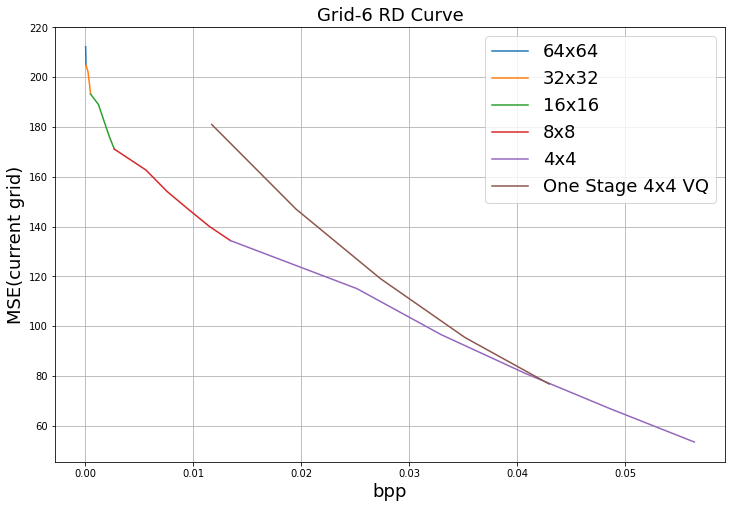

In [8]:
# oveerall RD

# 40 25 12

r1 = [4281/1427/1024/1024, 5708/1427/1024/1024, 7135/1427/1024/1024]
r1 = np.array(r1)*16
d1 = [212.23, 209.5, 204.8]

r2 = [0.00000476, 0.00000476+17124/1427/1024/1024, 0.00000476+28540/1427/1024/1024, 0.00000476+39956/1427/1024/1024]
r2 = np.array(r2)*16
d2 = [204.8, 202.3, 198, 193.2]

r3 = [0.0000314, 0.0000314+68496/1427/1024/1024, 0.0000314+114160/1427/1024/1024, 0.0000314+159824/1427/1024/1024, 0.0000314+205488/1427/1024/1024]
r3 = np.array(r3)*16
d3 = [193.2, 189, 182.7, 176.5, 171.1]

r4 = [0.000169, 0.000169+273984/1427/1024/1024, 0.000169+456640/1427/1024/1024, 0.000169+639296/1427/1024/1024, 0.000169+821952/1427/1024/1024, 0.000169+1004608/1427/1024/1024]
r4 = np.array(r4)*16
d4 = [171.1, 162.7, 154.1, 147, 140.1, 134.4]

r5 = [0.00084, 0.00084+1095936/1427/1024/1024, 0.00084+1826560/1427/1024/1024, 0.00084+2557184/1427/1024/1024, 0.00084+3287808/1427/1024/1024, 0.00084+4018432/1427/1024/1024]
r5 = np.array(r5)*16
d5 = [134.4, 115.1, 96.6, 81, 66.9, 53.5]

rr = [1095936/1427/1024/1024, 1826560/1427/1024/1024, 2557184/1427/1024/1024, 3287808/1427/1024/1024, 4018432/1427/1024/1024]
rr = np.array(rr)*16
dd = [181, 147, 119.1, 95.5, 76.8]
plt.figure(figsize=(12,8))
plt.plot(r1, d1, label='64x64')
plt.plot(r2, d2, label='32x32')
plt.plot(r3, d3, label='16x16')
plt.plot(r4, d4, label='8x8')
plt.plot(r5, d5, label='4x4')
plt.plot(rr, dd, label='One Stage 4x4 VQ')

# plt.scatter([3584], [201], c='red')
plt.grid()
plt.xlabel('bpp', fontsize=18)
plt.ylabel('MSE(current grid)', fontsize=18)
plt.title('Grid-6 RD Curve', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('g6.png')


plt.show()

In [8]:
# go to grid-7

DC_grid_7_Y_train_inv = LANCZOS.inv_split(DC_grid_6_Y_train_inv, (AC_grid_6_Y_train-r_s5), ratio=2)
AC_grid_7_Y_train_inv = DC_grid_8_Y_train - LANCZOS.resample(DC_grid_7_Y_train_inv, 1/2)

print(AC_grid_7_Y_train_inv.shape, MSE(AC_grid_7_Y_train_inv, AC_grid_7_Y_train))

(1427, 128, 128, 1) 106.4462426256272


In [9]:
# grid-7 band-1 new
codebook_size_128 = [8, 16, 32]
bit_map_1 = np.ones((1427, 1, 1), dtype=np.int32)
for c128 in codebook_size_128:
    X_inv_s1, r_s1, bits_s1, mse_s1 = slice_pca_VQ(AC_grid_7_Y_train_inv, 128, 100, c128, bit_map_1)  # band 1

    
# grid-7 band-2 new
codebook_size_64 = [8, 32, 128]
bit_map_2 = np.ones((1427, 2, 2), dtype=np.int32)
for c64 in codebook_size_64:
    X_inv_s2, r_s2, bits_s2, mse_s2 = slice_pca_VQ(r_s1, 64, 100, c64, bit_map_2)  # band 2
    
    
# grid-7 band-3 new
codebook_size_32 = [8, 32, 128, 512]
bit_map_3 = np.ones((1427, 4, 4), dtype=np.int32)
for c32 in codebook_size_32:
    X_inv_s3, r_s3, bits_s3, mse_s3 = slice_pca_VQ(r_s2, 32, 40, c32, bit_map_3)  # band 3
    
    
# grid-7 band-4 new
codebook_size_16 = [8, 32, 128, 512, 2048]
bit_map_4 = np.ones((1427, 8, 8), dtype=np.int32)
for c16 in codebook_size_16:
    X_inv_s4, r_s4, bits_s4, mse_s4 = slice_pca_VQ(r_s3, 16, 25, c16, bit_map_4)  # band 4
    
    
# grid-7 band-5 new
codebook_size_8 = [8, 32, 128, 512, 2048]
bit_map_5 = np.ones((1427, 16, 16), dtype=np.int32)
for c8 in codebook_size_8:
    X_inv_s5, r_s5, bits_s5, mse_s5 = slice_pca_VQ(r_s4, 8, 12, c8, bit_map_5)  # band 5
    
    
# grid-7 band-6 new
codebook_size_4 = [8, 32, 128, 512, 2048]
bit_map_6 = np.ones((1427, 32, 32), dtype=np.int32)
for c4 in codebook_size_4:
    X_inv_s6, r_s6, bits_s6, mse_s6 = slice_pca_VQ(r_s5, 4, 16, c4, bit_map_6)  # band 6

--------one band start--------
Window size:  128
Pick the first  100  channels, Energy ratio is:  0.25116152
Codebook size:  8
MSE:  241.17929284724175
Bits:  4281.0
--------one band stop---------
--------one band start--------
Window size:  128
Pick the first  100  channels, Energy ratio is:  0.2510892
Codebook size:  16
MSE:  237.82390124334424
Bits:  5708.0
--------one band stop---------
--------one band start--------
Window size:  128
Pick the first  100  channels, Energy ratio is:  0.25097165
Codebook size:  32
MSE:  231.05531107016057
Bits:  7135.0
--------one band stop---------
--------one band start--------
Window size:  64
Pick the first  100  channels, Energy ratio is:  0.21516379142575096
Codebook size:  8
MSE:  230.10930958401931
Bits:  17124.0
--------one band stop---------
--------one band start--------
Window size:  64
Pick the first  100  channels, Energy ratio is:  0.2153674302167104
Codebook size:  32
MSE:  227.8412667468505
Bits:  28540.0
--------one band stop-------

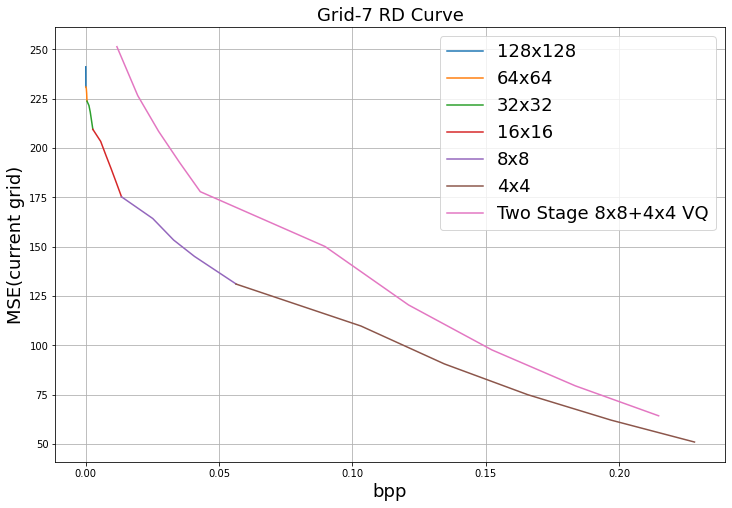

In [9]:
# oveerall RD

# 40 25 12

r1 = [4281/1427/1024/1024, 5708/1427/1024/1024, 7135/1427/1024/1024]
r1 = np.array(r1)*16
d1 = [241.2, 237.8, 231]

r2 = [0.00000476, 0.00000476+17124/1427/1024/1024, 0.00000476+28540/1427/1024/1024, 0.00000476+39956/1427/1024/1024]
r2 = np.array(r2)*16
d2 = [231, 230.1, 227.8, 223.8]

r3 = [0.0000314, 0.0000314+68496/1427/1024/1024, 0.0000314+114160/1427/1024/1024, 0.0000314+159824/1427/1024/1024, 0.0000314+205488/1427/1024/1024]
r3 = np.array(r3)*16
d3 = [223.8, 221.6, 218.3, 213.9, 209.5]

r4 = [0.000169, 0.000169+273984/1427/1024/1024, 0.000169+456640/1427/1024/1024, 0.000169+639296/1427/1024/1024, 0.000169+821952/1427/1024/1024, 0.000169+1004608/1427/1024/1024]
r4 = np.array(r4)*16
d4 = [209.5, 203.4, 196.4, 189.6, 182.5, 175.3]

r5 = [0.00084, 0.00084+1095936/1427/1024/1024, 0.00084+1826560/1427/1024/1024, 0.00084+2557184/1427/1024/1024, 0.00084+3287808/1427/1024/1024, 0.00084+4018432/1427/1024/1024]
r5 = np.array(r5)*16
d5 = [175.3, 164.3, 153.4, 145.1, 138.1, 131.1]

r6 = [0.00352, 0.00352+4383744/1427/1024/1024, 0.00352+7306240/1427/1024/1024, 0.00352+10228736/1427/1024/1024, 0.00352+13151232/1427/1024/1024, 0.00352+16073728/1427/1024/1024]
r6 = np.array(r6)*16
d6 = [131.1, 109.8, 90.6, 75, 62.1, 51]

rr = [1095936/1427/1024/1024, 1826560/1427/1024/1024, 2557184/1427/1024/1024, 3287808/1427/1024/1024, 4018432/1427/1024/1024, 0.00268+4383744/1427/1024/1024, 0.00268+7306240/1427/1024/1024, 0.00268+10228736/1427/1024/1024, 0.00268+13151232/1427/1024/1024, 0.00268+16073728/1427/1024/1024]
rr = np.array(rr)*16
dd = [251.4, 226.6, 208.5, 192.8, 177.9, 150.1, 120.5, 97.7, 79.5, 64.3]

plt.figure(figsize=(12,8))
plt.plot(r1, d1, label='128x128')
plt.plot(r2, d2, label='64x64')
plt.plot(r3, d3, label='32x32')
plt.plot(r4, d4, label='16x16')
plt.plot(r5, d5, label='8x8')
plt.plot(r6, d6, label='4x4')
plt.plot(rr, dd, label='Two Stage 8x8+4x4 VQ')

# plt.scatter([3584], [201], c='red')
plt.grid()
plt.xlabel('bpp', fontsize=18)
plt.ylabel('MSE(current grid)', fontsize=18)
plt.title('Grid-7 RD Curve', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('g7.png')


plt.show()

In [10]:
# go to grid-8

DC_grid_8_Y_train_inv = LANCZOS.inv_split(DC_grid_7_Y_train_inv, (AC_grid_7_Y_train-r_s6), ratio=2)
AC_grid_8_Y_train_inv = DC_grid_9_Y_train - LANCZOS.resample(DC_grid_8_Y_train_inv, 1/2)

print(AC_grid_8_Y_train_inv.shape, MSE(AC_grid_8_Y_train_inv, AC_grid_8_Y_train))

(1427, 256, 256, 1) 178.08486362513597


In [12]:
# grid-8 band-1 new
codebook_size_256 = [8, 16, 32]
bit_map_1 = np.ones((1427, 1, 1), dtype=np.int32)
for c256 in codebook_size_256:
    X_inv_s1, r_s1, bits_s1, mse_s1 = slice_pca_VQ(AC_grid_8_Y_train_inv, 256, 100, c256, bit_map_1)  # band 1

    
# grid-7 band-2 new
codebook_size_128 = [8, 32, 128]
bit_map_2 = np.ones((1427, 2, 2), dtype=np.int32)
for c128 in codebook_size_128:
    X_inv_s2, r_s2, bits_s2, mse_s2 = slice_pca_VQ(r_s1, 128, 100, c128, bit_map_2)  # band 2
    
    
# grid-7 band-3 new
codebook_size_64 = [8, 32, 128, 512]
bit_map_3 = np.ones((1427, 4, 4), dtype=np.int32)
for c64 in codebook_size_64:
    X_inv_s3, r_s3, bits_s3, mse_s3 = slice_pca_VQ(r_s2, 64, 100, c64, bit_map_3)  # band 3
    
    
# grid-7 band-4 new
codebook_size_32 = [8, 32, 128, 512, 2048]
bit_map_4 = np.ones((1427, 8, 8), dtype=np.int32)
for c32 in codebook_size_32:
    X_inv_s4, r_s4, bits_s4, mse_s4 = slice_pca_VQ(r_s3, 32, 40, c32, bit_map_4)  # band 4
    
    
# grid-7 band-5 new
codebook_size_16 = [8, 32, 128, 512, 2048]
bit_map_5 = np.ones((1427, 16, 16), dtype=np.int32)
for c16 in codebook_size_16:
    X_inv_s5, r_s5, bits_s5, mse_s5 = slice_pca_VQ(r_s4, 16, 25, c16, bit_map_5)  # band 5
    
    
# grid-7 band-6 new
codebook_size_8 = [8, 32, 128, 512, 2048]
bit_map_6 = np.ones((1427, 32, 32), dtype=np.int32)
for c8 in codebook_size_8:
    X_inv_s6, r_s6, bits_s6, mse_s6 = slice_pca_VQ(r_s5, 8, 12, c8, bit_map_6)  # band 6
    
    
# grid-7 band-7 new
codebook_size_4 = [8, 32, 128, 512, 2048]
bit_map_7 = np.ones((1427, 64, 64), dtype=np.int32)
for c4 in codebook_size_4:
    X_inv_s7, r_s7, bits_s7, mse_s7 = slice_pca_VQ(r_s6, 4, 16, c4, bit_map_7)  # band 7

--------one band start--------
Window size:  256
Pick the first  100  channels, Energy ratio is:  0.23706818
Codebook size:  8
MSE:  281.596258990874
Bits:  4281.0
--------one band stop---------
--------one band start--------
Window size:  256
Pick the first  100  channels, Energy ratio is:  0.23711418
Codebook size:  16
MSE:  277.99836696678216
Bits:  5708.0
--------one band stop---------
--------one band start--------
Window size:  256
Pick the first  100  channels, Energy ratio is:  0.23703419
Codebook size:  32
MSE:  272.0454551266565
Bits:  7135.0
--------one band stop---------
--------one band start--------
Window size:  128
Pick the first  100  channels, Energy ratio is:  0.2016038721581402
Codebook size:  8
MSE:  271.05103827134764
Bits:  17124.0
--------one band stop---------
--------one band start--------
Window size:  128
Pick the first  100  channels, Energy ratio is:  0.2017131598614426
Codebook size:  32
MSE:  269.0019804095209
Bits:  28540.0
--------one band stop--------

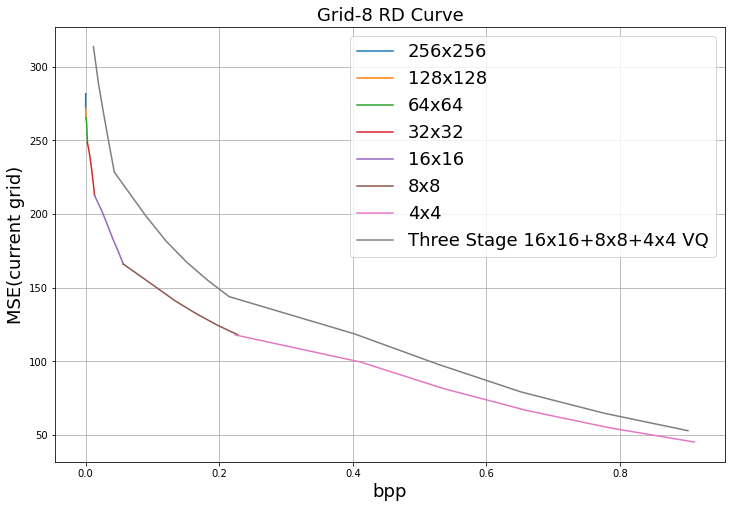

In [10]:
# oveerall RD

# 40 25 12

r1 = [4281/1427/1024/1024, 5708/1427/1024/1024, 7135/1427/1024/1024]
r1 = np.array(r1)*16
d1 = [281.6, 278, 272]

r2 = [0.00000476, 0.00000476+17124/1427/1024/1024, 0.00000476+28540/1427/1024/1024, 0.00000476+39956/1427/1024/1024]
r2 = np.array(r2)*16
d2 = [272, 271, 269, 265.2]

r3 = [0.0000314, 0.0000314+68496/1427/1024/1024, 0.0000314+114160/1427/1024/1024, 0.0000314+159824/1427/1024/1024, 0.0000314+205488/1427/1024/1024]
r3 = np.array(r3)*16
d3 = [265.2, 263.1, 260, 255, 248.6]

r4 = [0.000169, 0.000169+273984/1427/1024/1024, 0.000169+456640/1427/1024/1024, 0.000169+639296/1427/1024/1024, 0.000169+821952/1427/1024/1024, 0.000169+1004608/1427/1024/1024]
r4 = np.array(r4)*16
d4 = [248.6, 241.4, 235.2, 228.5, 220.8, 212.6]

r5 = [0.00084, 0.00084+1095936/1427/1024/1024, 0.00084+1826560/1427/1024/1024, 0.00084+2557184/1427/1024/1024, 0.00084+3287808/1427/1024/1024, 0.00084+4018432/1427/1024/1024]
r5 = np.array(r5)*16
d5 = [212.6, 201.2, 192.3, 183.1, 175, 166.1]

r6 = [0.00352, 0.00352+4383744/1427/1024/1024, 0.00352+7306240/1427/1024/1024, 0.00352+10228736/1427/1024/1024, 0.00352+13151232/1427/1024/1024, 0.00352+16073728/1427/1024/1024]
r6 = np.array(r6)*16
d6 = [166.1, 151.1, 141, 132.4, 124.7, 118]

r7 = [0.014, 0.014+17534976/1427/1024/1024, 0.014+29224960/1427/1024/1024, 0.014+40914944/1427/1024/1024, 0.014+52604928/1427/1024/1024, 0.014+64294912/1427/1024/1024]
r7 = np.array(r7)*16
d7 = [118, 99.6, 81.5, 66.6, 54.8, 45.3]

rr = [1095936/1427/1024/1024, 1826560/1427/1024/1024, 2557184/1427/1024/1024, 3287808/1427/1024/1024, 4018432/1427/1024/1024, 0.00268+4383744/1427/1024/1024, 0.00268+7306240/1427/1024/1024, 0.00268+10228736/1427/1024/1024, 0.00268+13151232/1427/1024/1024, 0.00268+16073728/1427/1024/1024, 0.0134+17534976/1427/1024/1024, 0.0134+29224960/1427/1024/1024, 0.0134+40914944/1427/1024/1024, 0.0134+52604928/1427/1024/1024, 0.0134+64294912/1427/1024/1024]
rr = np.array(rr)*16
dd = [313.6, 287.7, 267.2, 247.6, 228.5, 199, 181.4, 167, 154.8, 144, 118.8, 98.2, 79.3, 64.8, 53]
    


plt.figure(figsize=(12,8))
plt.plot(r1, d1, label='256x256')
plt.plot(r2, d2, label='128x128')
plt.plot(r3, d3, label='64x64')
plt.plot(r4, d4, label='32x32')
plt.plot(r5, d5, label='16x16')
plt.plot(r6, d6, label='8x8')
plt.plot(r7, d7, label='4x4')
plt.plot(rr, dd, label='Three Stage 16x16+8x8+4x4 VQ')

# plt.scatter([3584], [201], c='red')

plt.grid()
plt.xlabel('bpp', fontsize=18)
plt.ylabel('MSE(current grid)', fontsize=18)
plt.title('Grid-8 RD Curve', fontsize=18)
plt.legend(fontsize=18)
plt.savefig('g8.png')


plt.show()

In [28]:
0.000169+1004608/1427/1024/1024 + 0.00084+4018432/1427/1024/1024 + 0.00352+16073728/1427/1024/1024

0.01862812109375

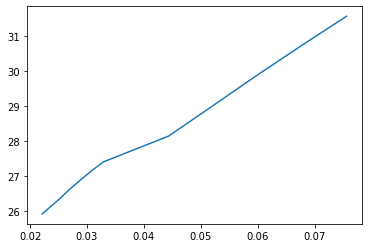

In [35]:
rr = [0.0186+0.00352, 0.0186+0.00352+4383744/1427/1024/1024, 0.0186+0.00352+7306240/1427/1024/1024, 0.0186+0.00352+10228736/1427/1024/1024, 0.0186+0.00352+13151232/1427/1024/1024, 0.0186+0.00352+16073728/1427/1024/1024, 0.0186+0.014+17534976/1427/1024/1024, 0.0186+0.014+29224960/1427/1024/1024, 0.0186+0.014+40914944/1427/1024/1024, 0.0186+0.014+52604928/1427/1024/1024, 0.0186+0.014+64294912/1427/1024/1024]
dd = [166.1, 151.1, 141, 132.4, 124.7, 118, 99.6, 81.5, 66.6, 54.8, 45.3]
psnr = []
for i in range(len(dd)):
    psnr.append(10*math.log(255*255/dd[i], 10))

plt.plot(rr, psnr, label='grid-8')
plt.show()

In [13]:
# go to grid-9

DC_grid_9_Y_train_inv = LANCZOS.inv_split(DC_grid_8_Y_train_inv, (AC_grid_8_Y_train-r_s7), ratio=2)
AC_grid_9_Y_train_inv = DC_grid_10_Y_train - LANCZOS.resample(DC_grid_9_Y_train_inv, 1/2)

print(AC_grid_9_Y_train_inv.shape, MSE(AC_grid_9_Y_train_inv, AC_grid_9_Y_train))

(1427, 512, 512, 1) 243.8589881474325


In [14]:
# grid-9 band-1 new
codebook_size_256 = [8, 16, 32]
bit_map_1 = np.ones((1427, 1, 1), dtype=np.int32)
for c256 in codebook_size_256:
    X_inv_s1, r_s1, bits_s1, mse_s1 = slice_pca_VQ(AC_grid_9_Y_train_inv, 512, 100, c256, bit_map_1)  # band 1

    
# grid-9 band-2 new
codebook_size_128 = [8, 32, 128]
bit_map_2 = np.ones((1427, 2, 2), dtype=np.int32)
for c128 in codebook_size_128:
    X_inv_s2, r_s2, bits_s2, mse_s2 = slice_pca_VQ(r_s1, 256, 100, c128, bit_map_2)  # band 2
    
    
# grid-9 band-3 new
codebook_size_64 = [8, 32, 128, 512]
bit_map_3 = np.ones((1427, 4, 4), dtype=np.int32)
for c64 in codebook_size_64:
    X_inv_s3, r_s3, bits_s3, mse_s3 = slice_pca_VQ(r_s2, 128, 100, c64, bit_map_3)  # band 3
    
    
# grid-9 band-4 new
codebook_size_32 = [8, 32, 128, 512, 2048]
bit_map_4 = np.ones((1427, 8, 8), dtype=np.int32)
for c32 in codebook_size_32:
    X_inv_s4, r_s4, bits_s4, mse_s4 = slice_pca_VQ(r_s3, 64, 100, c32, bit_map_4)  # band 4
    
    
# grid-9 band-5 new
codebook_size_16 = [8, 32, 128, 512, 2048]
bit_map_5 = np.ones((1427, 16, 16), dtype=np.int32)
for c16 in codebook_size_16:
    X_inv_s5, r_s5, bits_s5, mse_s5 = slice_pca_VQ(r_s4, 32, 40, c16, bit_map_5)  # band 5
    
    
# grid-9 band-6 new
codebook_size_8 = [8, 32, 128, 512, 2048]
bit_map_6 = np.ones((1427, 32, 32), dtype=np.int32)
for c8 in codebook_size_8:
    X_inv_s6, r_s6, bits_s6, mse_s6 = slice_pca_VQ(r_s5, 16, 25, c8, bit_map_6)  # band 6
    
    
# grid-9 band-7 new
codebook_size_4 = [8, 32, 128, 512, 2048]
bit_map_7 = np.ones((1427, 64, 64), dtype=np.int32)
for c4 in codebook_size_4:
    X_inv_s7, r_s7, bits_s7, mse_s7 = slice_pca_VQ(r_s6, 9, 12, c4, bit_map_7)  # band 7
    
    
# grid-9 band-8 new
codebook_size_4 = [8, 32, 128, 512, 2048]
bit_map_8 = np.ones((1427, 128, 128), dtype=np.int32)
for c4 in codebook_size_4:
    X_inv_s8, r_s8, bits_s8, mse_s8 = slice_pca_VQ(r_s7, 4, 16, c4, bit_map_8)  # band 8

--------one band start--------
Window size:  512
Pick the first  100  channels, Energy ratio is:  0.22452955
Codebook size:  8
MSE:  330.33913073888607
Bits:  4281.0
--------one band stop---------
--------one band start--------
Window size:  512
Pick the first  100  channels, Energy ratio is:  0.22461973
Codebook size:  16
MSE:  326.03258448203263
Bits:  5708.0
--------one band stop---------
--------one band start--------
Window size:  512
Pick the first  100  channels, Energy ratio is:  0.22444382
Codebook size:  32
MSE:  318.10006523687673
Bits:  7135.0
--------one band stop---------
--------one band start--------
Window size:  256
Pick the first  100  channels, Energy ratio is:  0.18202998159370265
Codebook size:  8
MSE:  317.01684490912737
Bits:  17124.0
--------one band stop---------
--------one band start--------
Window size:  256
Pick the first  100  channels, Energy ratio is:  0.18206887426418575
Codebook size:  32
MSE:  314.7568417529499
Bits:  28540.0
--------one band stop---

KeyboardInterrupt: 

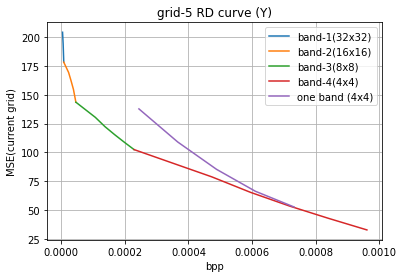

In [3]:
# oveerall RD

# 40 25 12

r1 = [5708/1427/1024/1024, 8562/1427/1024/1024, 11416/1427/1024/1024]
d1 = [204.17, 193.9, 178.2]

r2 = [0.0000076, 0.0000076+22832/1427/1024/1024, 0.0000076+34248/1427/1024/1024, 0.0000076+45664/1427/1024/1024, 0.0000076+57080/1427/1024/1024]
d2 = [178.2, 169.3, 162.2, 154.6, 143.5]

r3 = [0.0000458, 0.0000458+91328/1427/1024/1024, 0.0000458+136992/1427/1024/1024, 0.0000458+182656/1427/1024/1024, 0.0000458+228320/1427/1024/1024, 0.0000458+273984/1427/1024/1024]
d3 = [143.5, 130.4, 122.3, 115.34, 108.75, 102.4]

r4 = [0.000229, 0.000229+365312/1427/1024/1024, 0.000229+547968/1427/1024/1024, 0.000229+730624/1427/1024/1024, 0.000229+913280/1427/1024/1024, 0.000229+1095936/1427/1024/1024]
d4 = [102.4, 78.8, 65.34, 53.52, 42.9, 32.76]

rr = [365312/1427/1024/1024, 547968/1427/1024/1024, 730624/1427/1024/1024, 913280/1427/1024/1024, 1095936/1427/1024/1024]
dd = [137.7, 109, 85.3, 66.3, 52.63]
    
plt.plot(r1, d1, label='band-1(32x32)')
plt.plot(r2, d2, label='band-2(16x16)')
plt.plot(r3, d3, label='band-3(8x8)')
plt.plot(r4, d4, label='band-4(4x4)')
plt.plot(rr, dd, label='one band (4x4)')

# plt.scatter([3584], [201], c='red')
plt.grid()
plt.xlabel('bpp')
plt.ylabel('MSE(current grid)')
plt.title('grid-5 RD curve (Y)')
plt.legend()
plt.show()

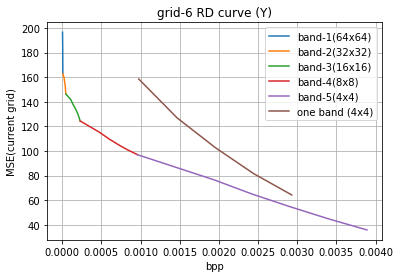

In [4]:
# oveerall RD

# 40 25 12

r1 = [5708/1427/1024/1024, 8562/1427/1024/1024, 11416/1427/1024/1024]
d1 = [196.5, 184.8, 162.65]

r2 = [0.0000076, 0.0000076+22832/1427/1024/1024, 0.0000076+34248/1427/1024/1024, 0.0000076+45664/1427/1024/1024, 0.0000076+57080/1427/1024/1024]
d2 = [162.65, 159.6, 156.4, 152.6, 146.3]

r3 = [0.0000458, 0.0000458+91328/1427/1024/1024, 0.0000458+136992/1427/1024/1024, 0.0000458+182656/1427/1024/1024, 0.0000458+228320/1427/1024/1024, 0.0000458+273984/1427/1024/1024]
d3 = [146.3, 142, 137.9, 134.4, 130.3, 124.4]

r4 = [0.000229, 0.000229+365312/1427/1024/1024, 0.000229+547968/1427/1024/1024, 0.000229+730624/1427/1024/1024, 0.000229+913280/1427/1024/1024, 0.000229+1095936/1427/1024/1024]
d4 = [124.4, 115.3, 109.9, 105.1, 100.77, 97]

r5 = [0.00096, 0.00096+1461248/1427/1024/1024, 0.00096+2191872/1427/1024/1024, 0.00096+2922496/1427/1024/1024, 0.00096+3653120/1427/1024/1024, 0.00096+4383744/1427/1024/1024]
d5 = [97, 76.6, 65, 54.62, 44.83, 35.87]

rr = [1461248/1427/1024/1024, 2191872/1427/1024/1024, 2922496/1427/1024/1024, 3653120/1427/1024/1024, 4383744/1427/1024/1024]
dd = [158.5, 127, 102.8, 81.7, 64.3]
    
plt.plot(r1, d1, label='band-1(64x64)')
plt.plot(r2, d2, label='band-2(32x32)')
plt.plot(r3, d3, label='band-3(16x16)')
plt.plot(r4, d4, label='band-4(8x8)')
plt.plot(r5, d5, label='band-5(4x4)')
plt.plot(rr, dd, label='one band (4x4)')

# plt.scatter([3584], [201], c='red')
plt.grid()
plt.xlabel('bpp')
plt.ylabel('MSE(current grid)')
plt.title('grid-6 RD curve (Y)')
plt.legend()
plt.show()

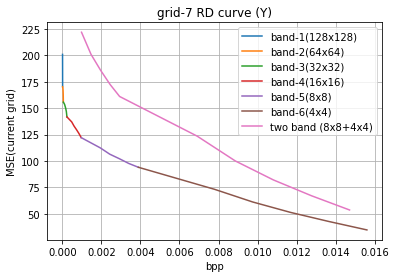

In [6]:
# oveerall RD

# 40 25 12

r1 = [5708/1427/1024/1024, 8562/1427/1024/1024, 11416/1427/1024/1024]
d1 = [201, 187.7, 170.3]

r2 = [0.0000076, 0.0000076+22832/1427/1024/1024, 0.0000076+34248/1427/1024/1024, 0.0000076+45664/1427/1024/1024, 0.0000076+57080/1427/1024/1024]
d2 = [170.3, 169, 167, 163.4, 155.7]

r3 = [0.0000458, 0.0000458+91328/1427/1024/1024, 0.0000458+136992/1427/1024/1024, 0.0000458+182656/1427/1024/1024, 0.0000458+228320/1427/1024/1024, 0.0000458+273984/1427/1024/1024]
d3 = [155.7, 153.7, 151.75, 149.7, 146.88, 141.74]

r4 = [0.000229, 0.000229+365312/1427/1024/1024, 0.000229+547968/1427/1024/1024, 0.000229+730624/1427/1024/1024, 0.000229+913280/1427/1024/1024, 0.000229+1095936/1427/1024/1024]
d4 = [141.74, 137, 133, 129.7, 126.14, 122.1]

r5 = [0.00096, 0.00096+1461248/1427/1024/1024, 0.00096+2191872/1427/1024/1024, 0.00096+2922496/1427/1024/1024, 0.00096+3653120/1427/1024/1024, 0.00096+4383744/1427/1024/1024]
d5 = [122.1, 112.4, 106.4, 102.13, 97.59, 94]

r6 = [0.00389, 0.00389+5844992/1427/1024/1024, 0.00389+8767488/1427/1024/1024, 0.00389+11689984/1427/1024/1024, 0.00389+14612480/1427/1024/1024, 0.00389+17534976/1427/1024/1024]
d6 = [94, 73.1, 61.1, 51.16, 42.6, 34.6]

rr = [1461248/1427/1024/1024, 2191872/1427/1024/1024, 2922496/1427/1024/1024, 3653120/1427/1024/1024, 4383744/1427/1024/1024, 0.003+5844992/1427/1024/1024, 0.003+8767488/1427/1024/1024, 0.003+11689984/1427/1024/1024, 0.003+14612480/1427/1024/1024, 0.003+17534976/1427/1024/1024]
dd = [222, 201, 186, 172.5, 161.1, 123.5, 100, 82, 67, 53.5]
    
plt.plot(r1, d1, label='band-1(128x128)')
plt.plot(r2, d2, label='band-2(64x64)')
plt.plot(r3, d3, label='band-3(32x32)')
plt.plot(r4, d4, label='band-4(16x16)')
plt.plot(r5, d5, label='band-5(8x8)')
plt.plot(r6, d6, label='band-6(4x4)')
plt.plot(rr, dd, label='two band (8x8+4x4)')

# plt.scatter([3584], [201], c='red')
plt.grid()
plt.xlabel('bpp')
plt.ylabel('MSE(current grid)')
plt.title('grid-7 RD curve (Y)')
plt.legend()
plt.show()